In [1]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from src.load_data import *
from src.graphs import *
from src.statistical_tests import *
from src.utils import *

In [2]:
# df = pd.read_excel('all_info/main_info.xlsx', sheet_name='wszystkie dane poprawione')
# df.to_csv('data.csv', index = False)

## Few notes:
* **total_clearance_between_visit** - wzgledem poprzedniej wizyty
* **clearance_between_visit** - wzgledem poczatku
* we group to **nereast** time group 


#### To-dos:
* Sprawdz ilosc grup z peaku w gory!
* Sprawdzic linear fit i non-linear fit
* Sprawdz rozne 
* Sprawdz methodologie
* Sila statystyczna (p-value)
* Sprawdz rozne kwartaly
* Pogrobic linie

#### Few **old** notes:
* The table above should include all information You need
* `wizyta po ilu zabiegach` -> can have some skipped zabiegy & can start at other point than 0
* `czas` -> defined as czas between this and next visit



# Hard-Coded Area:

In [3]:
import scipy.stats as stats
from statsmodels.stats.multicomp import MultiComparison
from collections import OrderedDict
from scipy.stats import ttest_rel as ttest_related
from scipy.stats import ttest_ind as ttest_not_related
from statistics import mean

df = get_data(format_type='all', remove_minus_ones = False)
bucket_column = 'visit_number'
# variable_column = "total_clearence_in_between_visits" 
variable_column = 'total_clearence_in_respect_to_beginning'

buckets = 'default'
limit = 20
increment = 3



buckets = [i for i in range(0,limit + 1, increment)]
buckets = [0,3,6,10,15]
data_dict = {}
data_2d_arr = []
for i in range(len(buckets) - 1):
    bucket_min = buckets[i]
    bucket_max = buckets[i+1]
    bucket_range = f"{bucket_min} - {bucket_max - 1}"

    visits_data = list(df.loc[(df[bucket_column] >= bucket_min) & (df[bucket_column] < bucket_max)][variable_column])
    data_dict[bucket_range] = visits_data
    data_2d_arr.append(visits_data)

# model = ols("observations ~ C(cotton_weight_percent)", df).fit()
# res = anova_lm(model, typ=1)

stats, p_value = stats.f_oneway(*data_2d_arr)
print('\n\n\n')
print('anova results:')
print(f'buckets: {buckets}')
print(f'p_value: {p_value}\n')



to_be_plot_data = []
dict_len = len(data_dict)
means = []
p_values = []
prev_data = ''
prev_bucket_range = ''
bucket_ranges = []
for bucket_range, data in data_dict.items():
    if bucket_range == '0 - 2':
        bucket_range = '1 - 2'

    means.append(round(mean(data),2))
    bucket_ranges.append(bucket_range)
    if prev_data == '' :
        prev_data = data
        prev_bucket_range = bucket_range
        continue

    left_mean = round(mean(prev_data),2)
    right_mean = round(mean(data),2)
    statistics, p_value = ttest_not_related(prev_data, data, alternative= 'less')
    p_value = round(p_value,5)
    print(f'statistics between {prev_bucket_range} bucket and {bucket_range} bucket')
    print(f'means: {left_mean} vs {right_mean}')
    print(f"p-value: {p_value}\n")
    p_values.append(p_value)
    to_be_plot_data.append([bucket_range, left_mean, right_mean, p_value])

    prev_data = data
    prev_bucket_range = bucket_range

default time group has GROUPS defined as: [0, 90, 180, 270, 360]




anova results:
buckets: [0, 3, 6, 10, 15]
p_value: 1.8411125364292614e-17

statistics between 1 - 2 bucket and 3 - 5 bucket
means: 23.53 vs 41.85
p-value: 0.0

statistics between 3 - 5 bucket and 6 - 9 bucket
means: 41.85 vs 54.09
p-value: 0.00015

statistics between 6 - 9 bucket and 10 - 14 bucket
means: 54.09 vs 52.47
p-value: 0.67061



In [28]:
p_values[2] = 'n.s.'
plt.figure(figsize=(20,10))

index = 1
x_ticks = []

buckets = []
for i, bucket_range in enumerate(bucket_ranges):
    if i == 0 or i == len(bucket_ranges) - 1:
        buckets.append(bucket_range)
    else : 
        buckets.append(bucket_range)
        buckets.append(bucket_range)




for i, mean in enumerate(means):
    X_AXIS_INCREMENT = 0.5
    BREAK_INCREMENT = 2

    if index == 1:
        X_axis_index = X_AXIS_INCREMENT * index
        data = mean

    elif i == len(means) - 1 :
        X_axis_index = X_AXIS_INCREMENT * index
        data = mean

    else :
        X_axis_index = [index * X_AXIS_INCREMENT, (index + 2) * X_AXIS_INCREMENT ]
        data = [mean, mean]
        index += BREAK_INCREMENT

    plt.bar(X_axis_index, data, 0.4)
    # print(X_axis_index)
    index += 1


    # Get ticks
    if type(X_axis_index) == list:
        for i in X_axis_index:
            x_ticks.append(i)
    else :
        x_ticks.append(X_axis_index)


    
plt.xticks(x_ticks, buckets)
plt.xlabel('number of laser sessions (clustered into buckets)', fontsize=17)
plt.ylabel('% mean improvement\n(total clearance)\n', fontsize=19)

ax = plt.gca()


labels_places = []
for i in range(len(x_ticks) - 1):
    if i%2 == 1:
        continue
    before = x_ticks[i]
    after = x_ticks[i+1]
    label_place = (before+after)/2
    labels_places.append(label_place)


for label, p_value  in zip(labels_places, p_values):
    height = 54.50
    if p_value == 'n.s.':
        text = 'n.s.'
    else : 
        text = f"p-value: {p_value}"
    ax.text(
        label, height, text, ha="center", va="bottom", size = 18
    )
ax = plt.gca()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14.5)

plt.show()

In [5]:
non_moved_df = get_data(format_type='all')
moved_df = get_data(format_type='moved_to_0')
non0s_df = get_data(format_type='all_without_0s')

print('looking at the moved data:')
moved_df.head(10)

default time group has GROUPS defined as: [0, 90, 180, 270, 360]
default time group has GROUPS defined as: [0, 90, 180, 270, 360]
default time group has GROUPS defined as: [0, 90, 180, 270, 360]
looking at the moved data:


,surname,time,summed_time,time_group,visit_number,total_clearence_in_between_visits,total_clearence_in_respect_to_beginning,------------,unmoved_visit_nr
0,1.Gasek,57,57,1,1,10.43594,10.435942,,1
1,1.Gasek,958,1015,4,2,-1.90988,8.725376,,2
2,1.Gasek,70,1085,1,3,-3.15234,5.848092,,3
3,1.Gasek,63,1148,1,4,26.20423,30.519873,,4
4,1.Gasek,238,1386,3,5,-0.99610,29.827784,,5
5,2. Kołodziejska,217,217,2,1,66.95658,66.956580,,1
6,2. Kołodziejska,42,259,0,2,20.93472,73.874130,,2
7,2. Kołodziejska,26,306,0,5,-59.55360,71.032640,,5
8,2. Kołodziejska,294,600,3,6,76.67272,93.242700,,6
9,4. Krzysztoń,35,66,0,1,-18.03010,-13.664000,,3


### Wyniki - totalna poprawa:

In [6]:
get_stats_for_abstract(df = None, format_type = 'all')

default time group has GROUPS defined as: [0, 90, 180, 270, 360]
median of maximum total clearence: 59.613085
% of patients that had a total_clearence of minimum 25%: 82.25806451612904
% of patients that had a total_clearence of minimum 50%: 67.74193548387096
% of patients that had a total_clearence of minimum 75%: 24.193548387096776
% of patients that had a total_clearence of minimum 90%: 4.838709677419355


,surname,total_clearence_in_respect_to_beginning
0,1.Gasek,30.519873
1,10.Będzinowski szyja,70.360110
2,11. Cicha-kwiecień,52.934780
3,12. Januszewska,60.984150
4,13.Zborowski,77.379030
...,...,...
57,7. Kowal,82.977240
58,70. Wójcicki,83.173308
59,71. Zając,9.855161
60,8.Wierny,71.835400


In [7]:
get_stats_for_abstract2(df = None, format_type = 'all', visit_number_buckets = [0,2,5,10,15,20])

default time group has GROUPS defined as: [0, 90, 180, 270, 360]
bucket: 2
bucket: 5
bucket: 10
bucket: 15
bucket: 20
[29.24616, 45.51749, 56.58685316, 56.99166, 56.97438]


,surname,total_clearence_in_respect_to_beginning
0,1.Gasek,30.519873
1,10.Będzinowski szyja,60.169450
2,11. Cicha-kwiecień,52.934780
3,12. Januszewska,60.984150
4,13.Zborowski,77.379030
...,...,...
57,7. Kowal,82.977240
58,70. Wójcicki,83.173308
59,71. Zając,9.855161
60,8.Wierny,71.835400


In [8]:
# Print some overall info such as:
# nr of people w. different number of visits
# nr of people in different waiting buckets

# Main Graphs
### Total clearence compared to start:

default time group has GROUPS defined as: [0, 90, 180, 270, 360]
default time group has GROUPS defined as: [0, 90, 180, 270, 360]
default time group has GROUPS defined as: [0, 90, 180, 270, 360]


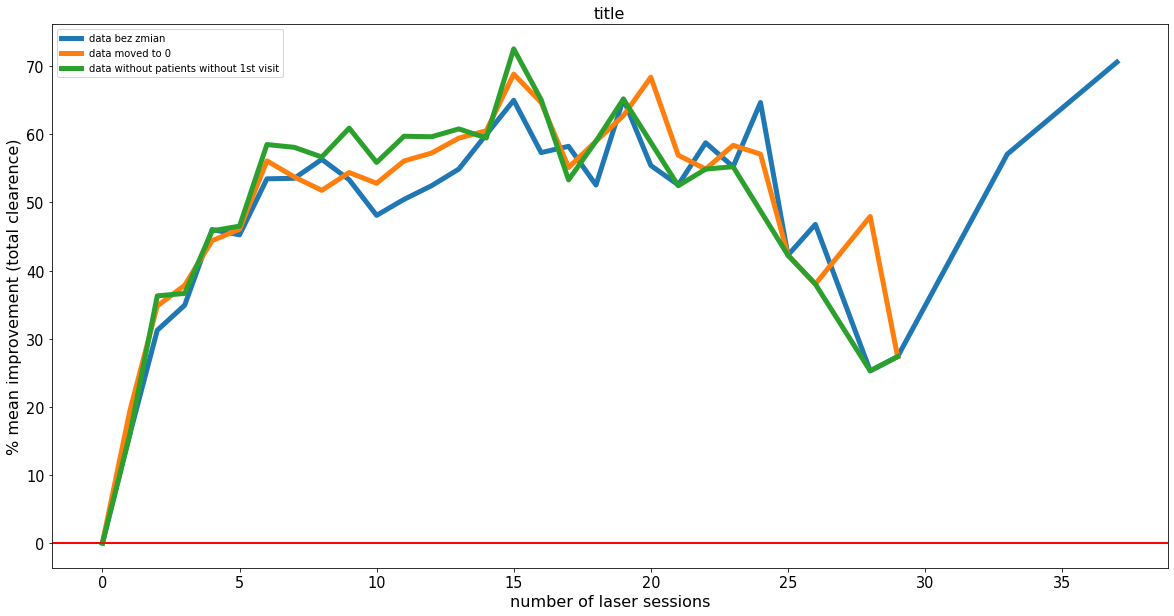

In [9]:
plt.figure(figsize=(20,10))
data = get_data(format_type='all',remove_minus_ones = False )
data2 = get_data(format_type='moved_to_0',remove_minus_ones = False )
data3 = get_data(format_type='all_without_0s',remove_minus_ones = False )
agg_column_graph(data, label = 'data bez zmian', column = 'total_clearence_in_respect_to_beginning')
agg_column_graph(data2, label = 'data moved to 0', column = 'total_clearence_in_respect_to_beginning')
agg_column_graph(data3, label = 'data without patients without 1st visit', column = 'total_clearence_in_respect_to_beginning', title = 'title')

No handles with labels found to put in legend.


default time group has GROUPS defined as: [0, 90, 180, 270, 360]


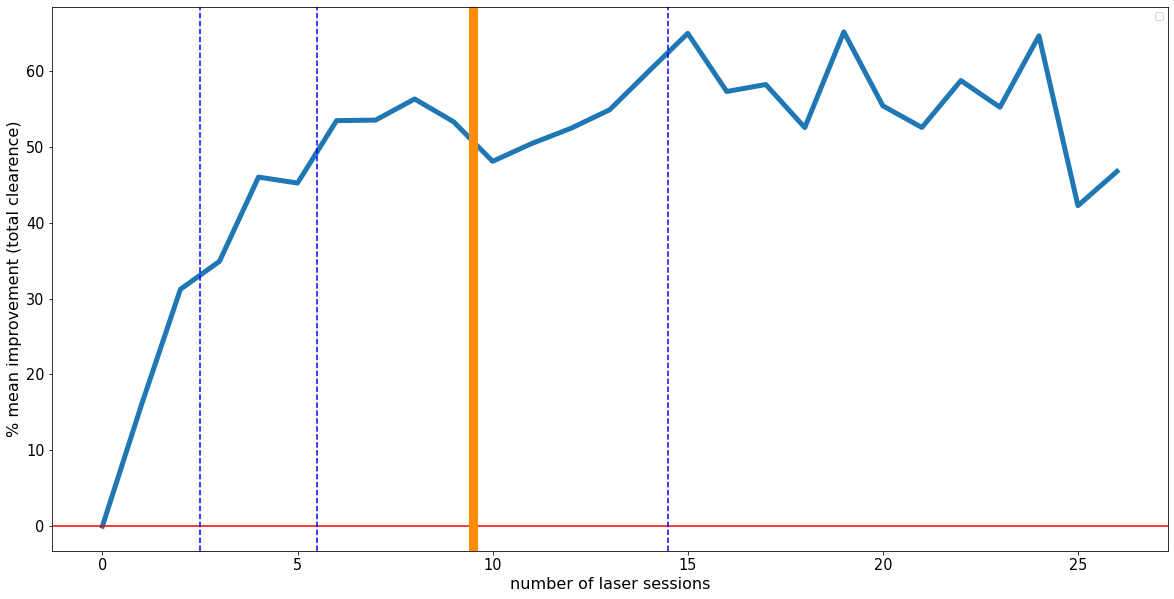

In [10]:
plt.figure(figsize=(20,10))
data = get_data(format_type='all',remove_minus_ones = False )
agg_column_graph(data, label = '', column = 'total_clearence_in_respect_to_beginning', title = '', cut_last_x_visits = 27)
plt.axvline(x=2.5, color='b', linestyle='--')
plt.axvline(x=5.5, color='b', linestyle='--')
plt.axvline(x=14.5, color='b', linestyle='--')
plt.axvline(x=9.5, color='darkorange', linestyle='-',  lw = 9)

# Logaithmic and polynomial fits
# If the logathmic fit is the best fit
# Anova -> posthoc ttest ()
# Plot the scatter of data for better visibility 
# (try moving avg for smoothen avg)

No handles with labels found to put in legend.


default time group has GROUPS defined as: [0, 90, 180, 270, 360]


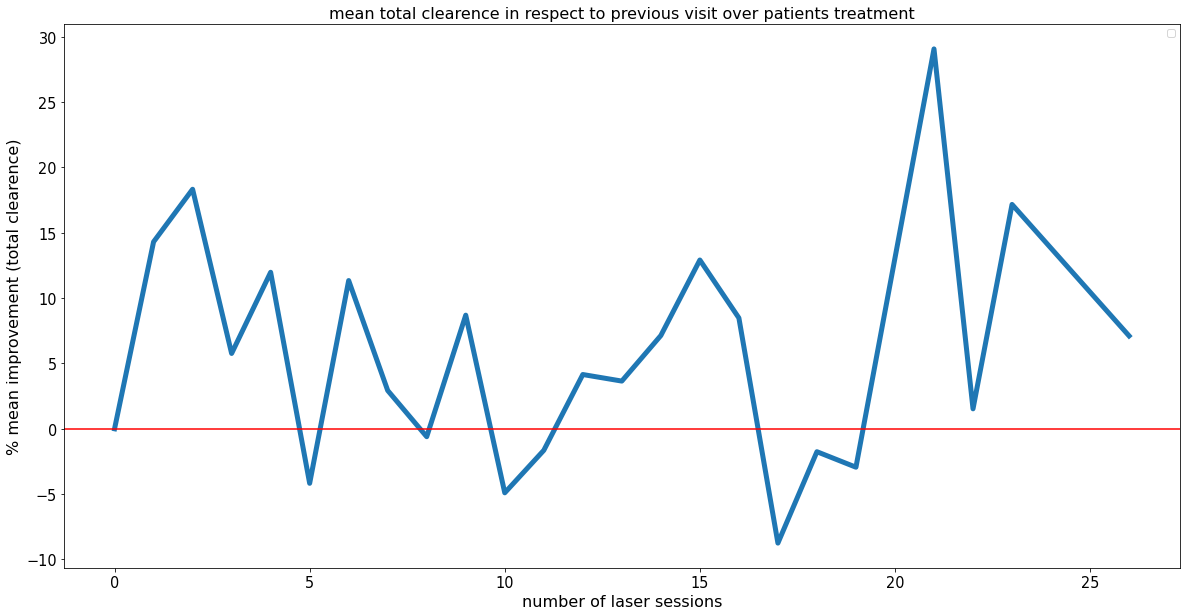

In [11]:
data = get_data(format_type='all',remove_minus_ones = True )
plt.figure(figsize=(20,10))
agg_column_graph(data, label = '', column = 'total_clearence_in_between_visits', title = 'mean total clearence in respect to previous visit over patients treatment', cut_last_x_visits = 26)

### Srednia poprawa miedzy wizytami:

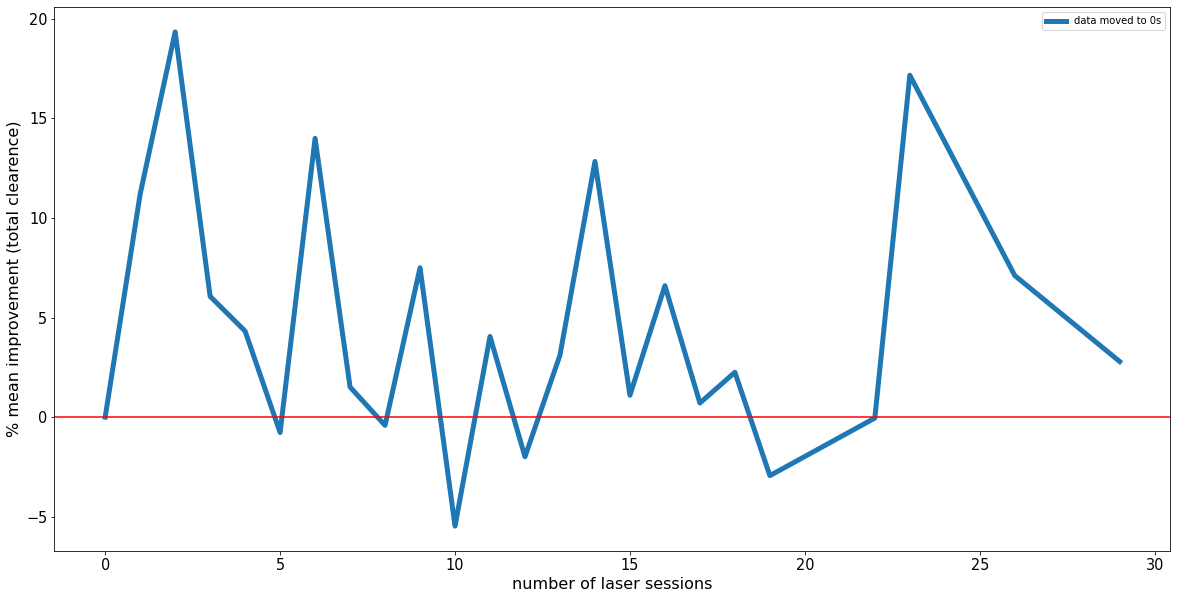

In [12]:
plt.figure(figsize=(20,10))
plt.title("srednia poprawa miedzy wizytami")
agg_column_graph(moved_df, label = 'data moved to 0s')
plt.legend()

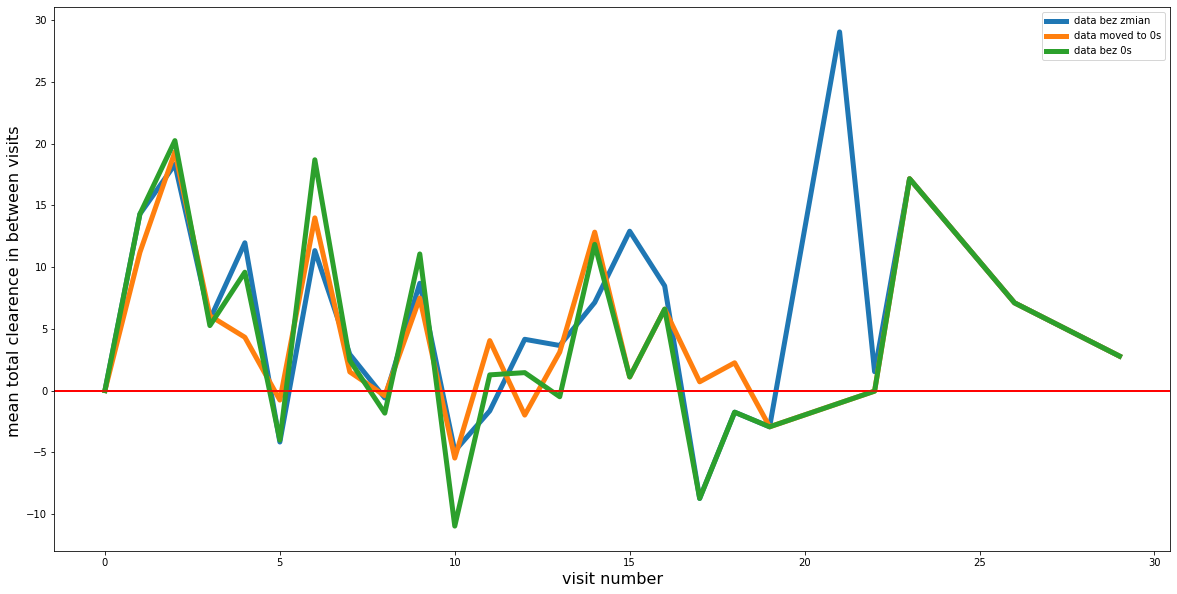

In [ ]:
plt.figure(figsize=(20,10))
agg_column_graph(non_moved_df, label = 'data bez zmian', column = 'total_clearence_in_between_visits')
agg_column_graph(moved_df, label = 'data moved to 0s', column = 'total_clearence_in_between_visits')
agg_column_graph(non0s_df, label = 'data bez 0s', column = 'total_clearence_in_between_visits')

### Showcase of how tests works:

In [ ]:
chi_squared_test(non_moved_df.loc[non_moved_df['visit_number']> 0], name = 'example test', display_data = True)


,surname,time,summed_time,time_group,visit_number,total_clearence_in_between_visits,total_clearence_in_respect_to_beginning,------------,below 0
0,1.Gasek,57,57,1,1,10.43594,10.435942,,False
1,1.Gasek,958,1015,4,2,-1.90988,8.725376,,True
2,1.Gasek,70,1085,1,3,-3.15234,5.848092,,True
3,1.Gasek,63,1148,1,4,26.20423,30.519873,,False
4,1.Gasek,238,1386,3,5,-0.99610,29.827784,,True


GROUPS: [0, 90, 180, 270, 360]


time_group,0,1,2,3,4
below 0,,,,,
False,106,97,20,6,2
True,53,38,8,5,8


p-value of chi squred contigency test for example test: 0.013965065006641913 (w. Yates correction - good practice)
expected frequencies were:


,0,1,2,3,4
False,107.081633,90.918367,18.857143,7.408163,6.734694
True,51.918367,44.081633,9.142857,3.591837,3.265306


In [7]:
plt.figure(figsize=(20,12))
time_group_based_avg_graph(moved_df, 
                           GROUPS = [0,10,20], 
                           increment = 10, 
                           display_data_for_chi_square_test = False, 
                           base_column = 'nr_visit_group',
                           column = 'total_clearence_in_between_visits')

NameError: name 'moved_df' is not defined

<Figure size 1440x864 with 0 Axes>

Pearsons correlation of the linear fit for nie przesunieci: -0.578 (very bad practice though)
p-value of chi squred contigency test for nie przesunieci: 0.11550297843162574 (w. Yates correction - good practice)

Pearsons correlation of the linear fit for przesunieci: -0.656 (very bad practice though)
p-value of chi squred contigency test for przesunieci: 0.03706652483286407 (w. Yates correction - good practice)

Pearsons correlation of the linear fit for usunieci bez 1 wizyty: -0.756 (very bad practice though)
p-value of chi squred contigency test for usunieci bez 1 wizyty: 0.048514339710786857 (w. Yates correction - good practice)



,nr_visit_group,patients_in_bucket nie przesunieci
0,0,79
1,5,141
2,10,75
3,15,36
4,20,12


Text(0.5, 0, 'nr_visits_group')

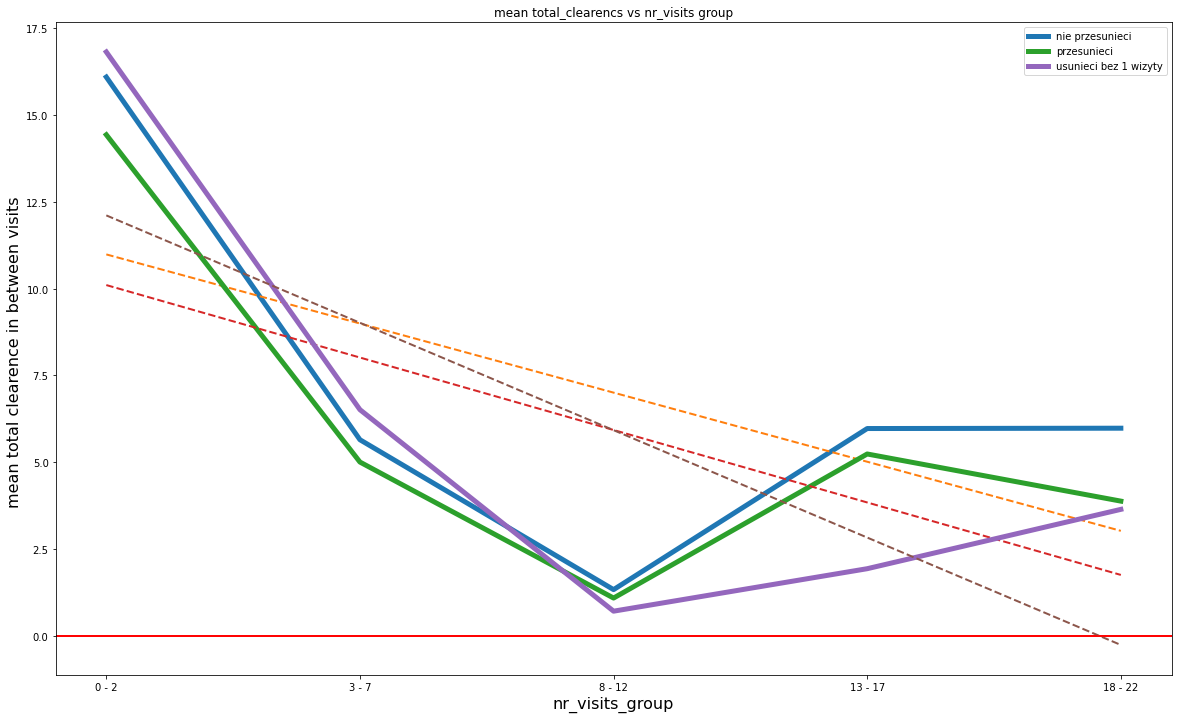

In [ ]:
plt.figure(figsize=(20,12))
a = time_group_based_avg_graph(non_moved_df, 
                           GROUPS = [0,5,10,15,20], 
                           increment = 5, 
                           display_data_for_chi_square_test = False, 
                           base_column = 'nr_visit_group',
                           column = 'total_clearence_in_between_visits',
                           label = 'nie przesunieci')
time_group_based_avg_graph(moved_df, 
                           GROUPS = [0,5,10,15,20], 
                           increment = 5, 
                           display_data_for_chi_square_test = False, 
                           base_column = 'nr_visit_group',
                           column = 'total_clearence_in_between_visits',
                           label = 'przesunieci')

time_group_based_avg_graph(non0s_df, 
                           GROUPS = [0,5,10,15,20], 
                           increment = 5, 
                           display_data_for_chi_square_test = False, 
                           base_column = 'nr_visit_group',
                           column = 'total_clearence_in_between_visits',
                           label = 'usunieci bez 1 wizyty')
display(a)
plt.title('mean total_clearencs vs nr_visits group')
plt.xlabel('nr_visits_group')

## Time Group based avg graphs:
* Removed graphs for patients after 15th and 20th visit - since there is barely any data there

In [8]:
graph_multiple_time_group_based_avg_graph(non_moved_df,blizsze = False, GROUPS = [0,100,200], increment = 100)

NameError: name 'non_moved_df' is not defined

In [9]:
graph_multiple_time_group_based_avg_graph(non_moved_df,blizsze = False, GROUPS = [0,200,400], increment = 200)

NameError: name 'non_moved_df' is not defined

In [ ]:
# graph_multiple_time_group_based_avg_graph(non_moved_df,blizsze = False, GROUPS = [0,100,200,300], increment = 100) # I dont like this one

default time group has GROUPS defined as: [0, 90, 180, 270, 360]
p-value of chi squred contigency test for visits with nunber 5 and further: 0.5501818931996454 (w. Yates correction - good practice)

p-value of chi squred contigency test for all visits: 0.0057701342905184414 (w. Yates correction - good practice)



,time_group,patients_in_bucket visits with nunber 5 and further,patients_in_bucket all visits
0,0,120,214
1,120,57,94
2,240,23,25
3,360,3,10


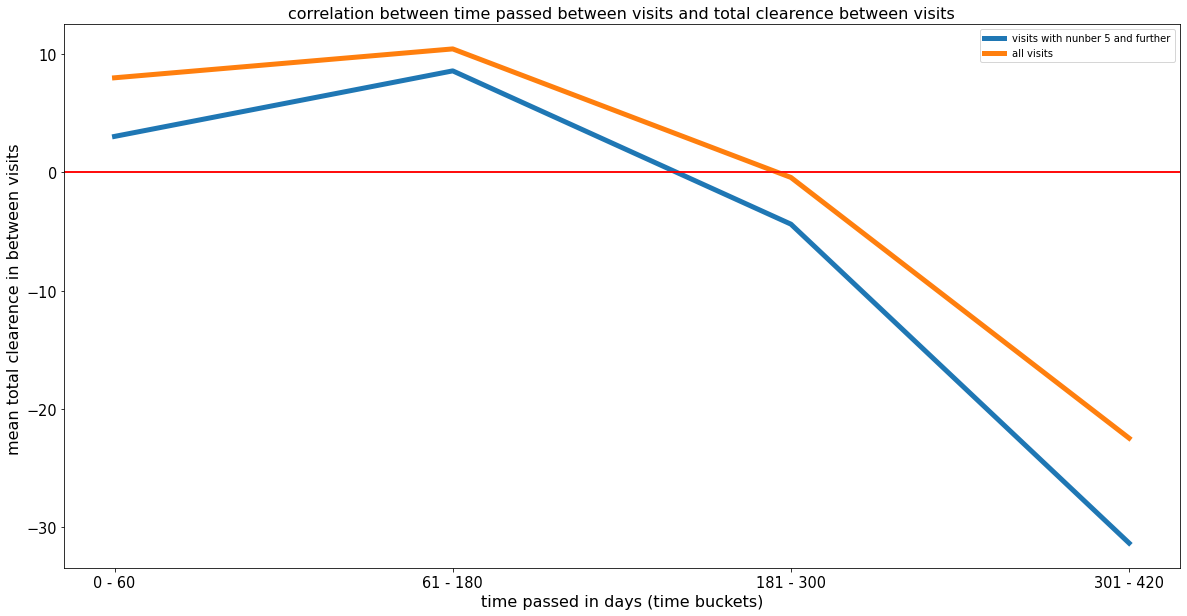

In [10]:
data = get_data(format_type='all',remove_minus_ones = True )
graph_multiple_time_group_based_avg_graph(data,blizsze = False, GROUPS = [0,120,240,360], increment = 120, skip_linear_fit = True, wizyty_iteration = [5,0])

In [11]:
graph_multiple_time_group_based_avg_graph(non_moved_df,blizsze = False, GROUPS = [0,90,180,270,360], increment=90)

NameError: name 'non_moved_df' is not defined

Pearsons correlation of the linear fit for visits with nunber 10 and further: -0.571 (very bad practice though)
p-value of chi squred contigency test for visits with nunber 10 and further: nan (w. Yates correction - good practice)

Pearsons correlation of the linear fit for visits with nunber 5 and further: -0.339 (very bad practice though)
p-value of chi squred contigency test for visits with nunber 5 and further: nan (w. Yates correction - good practice)

Pearsons correlation of the linear fit for visits with nunber 3 and further: -0.397 (very bad practice though)
p-value of chi squred contigency test for visits with nunber 3 and further: nan (w. Yates correction - good practice)

Pearsons correlation of the linear fit for all visits: -0.405 (very bad practice though)
p-value of chi squred contigency test for all visits: nan (w. Yates correction - good practice)



,time_group,patients_in_bucket visits with nunber 10 and further,patients_in_bucket visits with nunber 5 and further,patients_in_bucket visits with nunber 3 and further,patients_in_bucket all visits
0,0,1,1,1,1
1,30,46,94,120,158
2,60,18,41,61,84
3,90,5,25,32,38
4,120,1,7,10,13
5,150,1,6,8,10
6,180,5,9,9,10
7,210,4,7,7,8
8,240,1,5,5,6
9,270,1,3,3,3


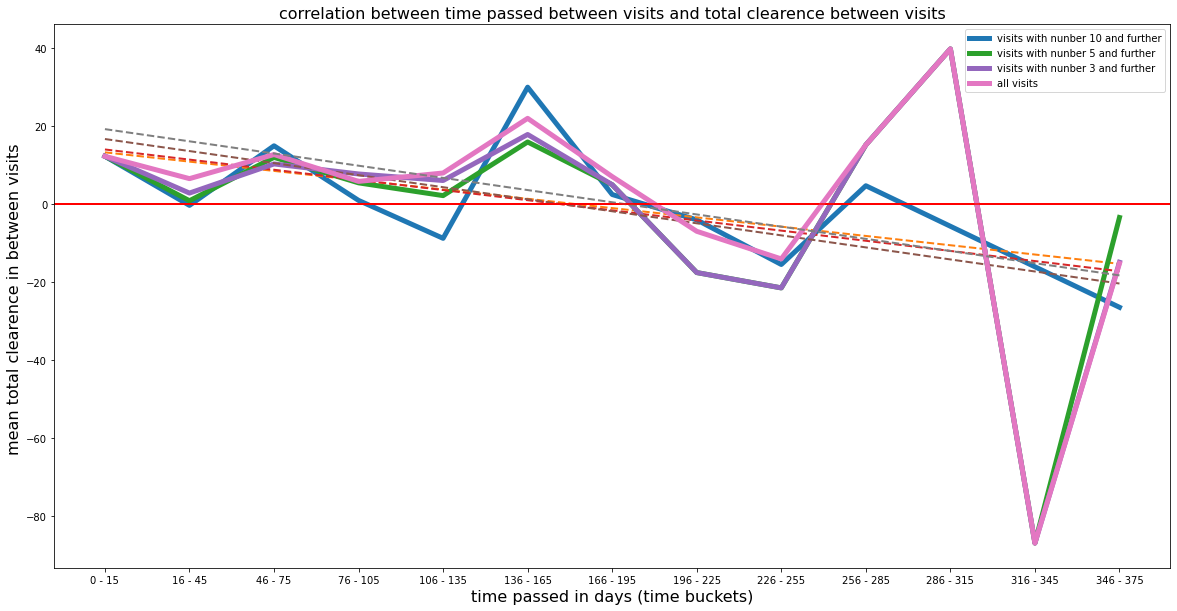

In [ ]:
graph_multiple_time_group_based_avg_graph(non_moved_df,blizsze = False, GROUPS = [0,30,60,90,120,150,180,210,240,270,300,330,360], increment=30)

### All users plots:

In [12]:
# plot_all_users(non_moved_df, title = 'data bez zmian')
# plot_all_users(moved_df, title = 'data moved to 0s')
# plot_all_users(non0s_df, title = 'data bez 0s')

In [13]:
plt.figure(figsize=(20,12))
scatter_plot_against_time(non_moved_df, label = 'before or 5th visit', label2 ='line fit to ALL data' ,plot_linear_fit = False)

NameError: name 'non_moved_df' is not defined

<Figure size 1440x864 with 0 Axes>

## Scatter plots - dependent on visit:

In [14]:
plt.figure(figsize=(20,12))
scatter_plot_against_time(non_moved_df.loc[non_moved_df['visit_number'] > 2], label = 'before or 5th visit', label2 ='line fit to ALL data' ,plot_linear_fit = True)

NameError: name 'non_moved_df' is not defined

<Figure size 1440x864 with 0 Axes>

## Scatter plots - dependent on visit:

0.032020892871741265
-0.2415020277973625
2.932005132009721
0.023324697819204397
-0.24027839683451185
2.7445699711160016
0.8915705204864695
0.011710209352865389
3.0818044515817324
0.15537499226163395
-0.23837701963120947
4.826179334210022


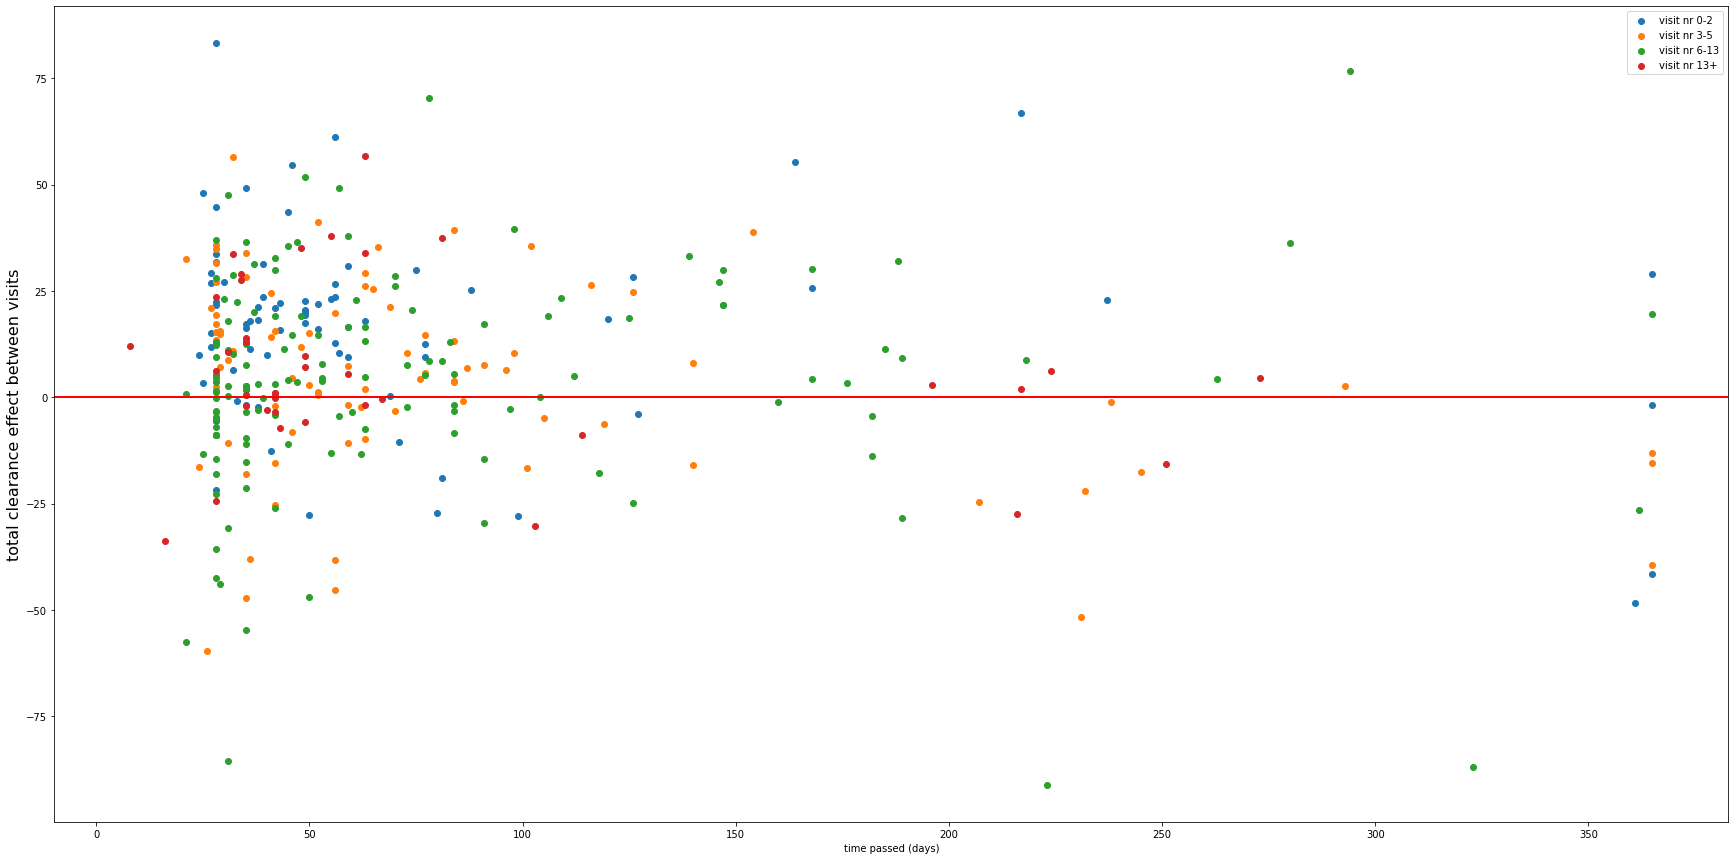

In [28]:
plt.figure(figsize=(30,15))

df1 = non_moved_df.loc[non_moved_df['visit_number'].isin([1,2])]
df2 = non_moved_df.loc[non_moved_df['visit_number'].isin([3,4,5])]
df3 = non_moved_df.loc[non_moved_df['visit_number'].isin([6,7,8,9,10,11,12,13])]
df5 = non_moved_df.loc[non_moved_df['visit_number'] > 13]


scatter_plot_against_time(df1, label = 'visit nr 0-2', plot_linear_fit= False)
scatter_plot_against_time(df2, label = 'visit nr 3-5', plot_linear_fit= False)
scatter_plot_against_time(df3, label = 'visit nr 6-13', plot_linear_fit= False)
scatter_plot_against_time(df5, label = 'visit nr 13+', plot_linear_fit= False)
plt.legend()

In [29]:
# weird_data = non_moved_df.loc[(non_moved_df['below 0'] == True) & (non_moved_df['time'] <75)] # Send to Michal & Professor
# weird_data.to_excel('dziwne_badania.xlsx')

0.007026365387323334
-0.14530548142261068
1.5945689831327972
Pearsons correlation: -0.153
0.054316544006900856
-0.11857720947819712
1.849430683780543
Pearsons correlation: -0.131


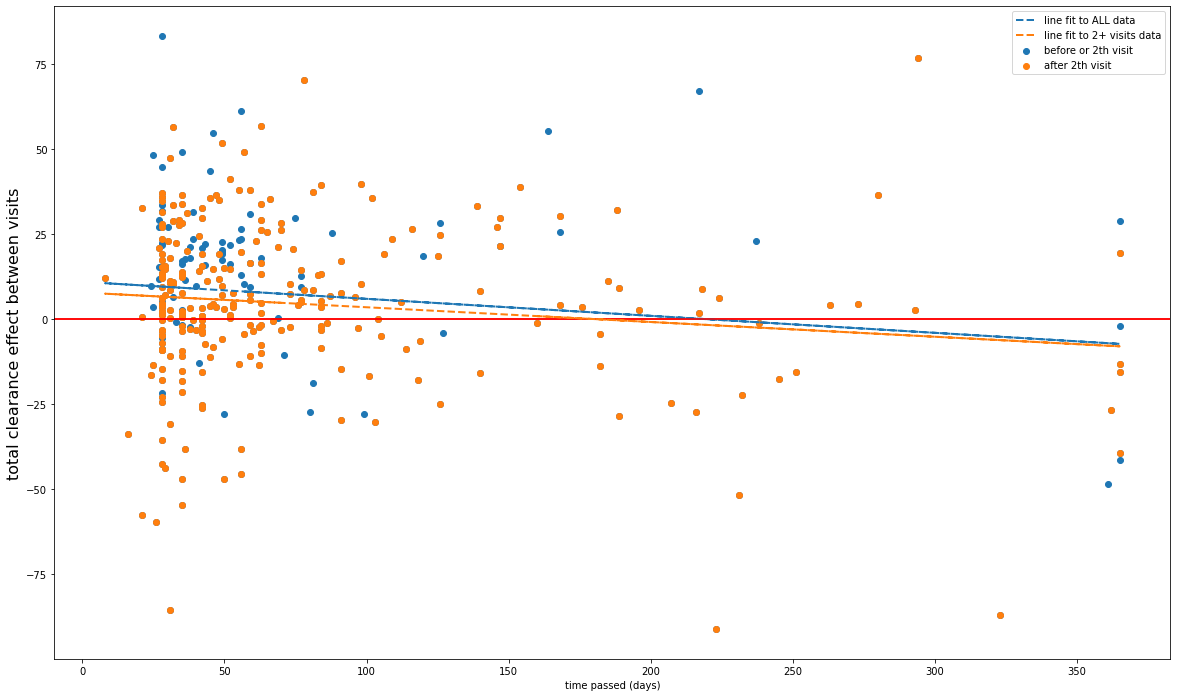

In [30]:
plt.figure(figsize=(20,12))
scatter_plot_against_time(non_moved_df, label = 'before or 2th visit', label2 ='line fit to ALL data')
scatter_plot_against_time(non_moved_df.loc[non_moved_df['visit_number'] > 2], label = 'after 2th visit', label2= 'line fit to 2+ visits data')
plt.legend()

If time was longer than 360 I changed it to 360 to keep graph readable 

0.007026365387323334
-0.14530548142261068
1.5945689831327972
Pearsons correlation: -0.153
0.7137361076603865
-0.02792544317206038
2.64176958012816
Pearsons correlation: -0.044


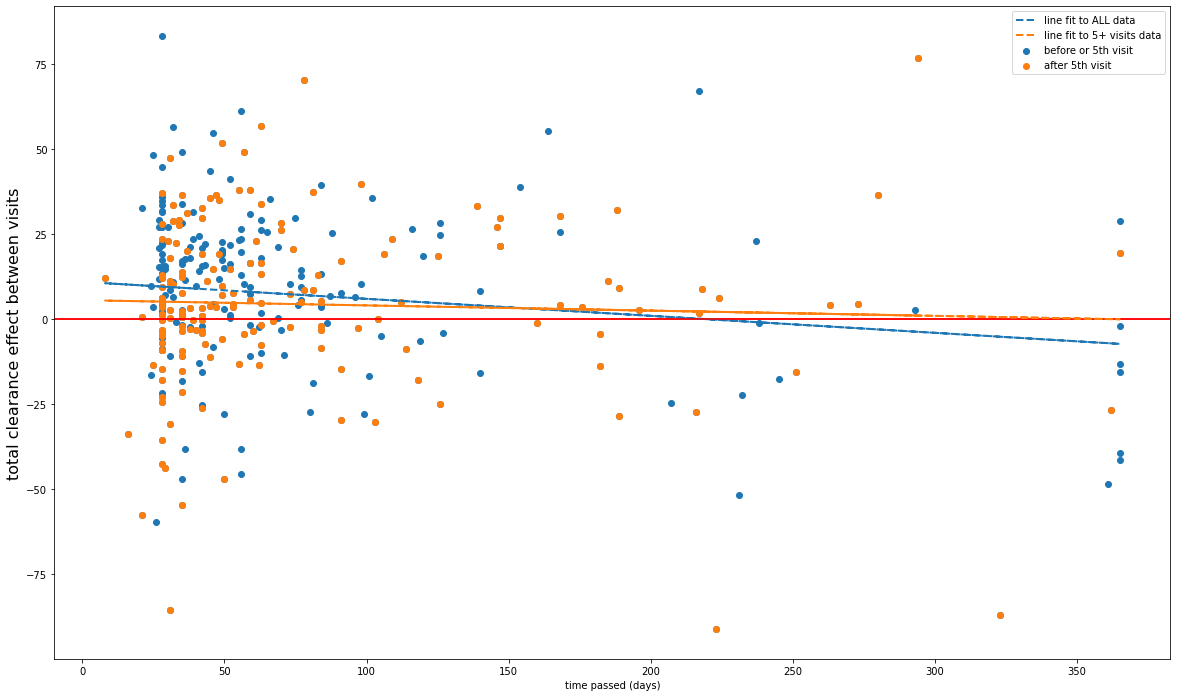

In [31]:
print('If time was longer than 360 I changed it to 360 to keep graph readable \n')

plt.figure(figsize=(20,12))
scatter_plot_against_time(non_moved_df, label = 'before or 5th visit', label2 ='line fit to ALL data')
scatter_plot_against_time(non_moved_df.loc[non_moved_df['visit_number'] > 5], label = 'after 5th visit', label2= 'line fit to 5+ visits data')
plt.legend()

0.007026365387323334
-0.14530548142261068
1.5945689831327972
Pearsons correlation: -0.153
0.07043838747960024
-0.21599028749947752
3.102478945654363
Pearsons correlation: -0.216


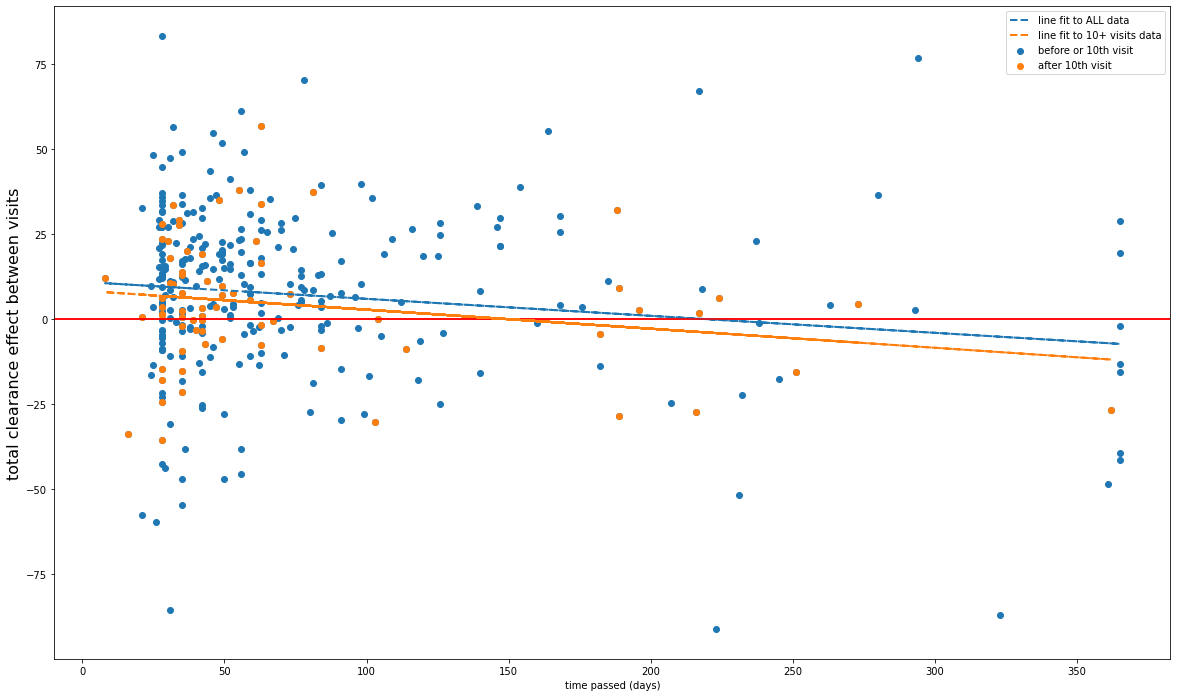

In [32]:
plt.figure(figsize=(20,12))
scatter_plot_against_time(non_moved_df, label = 'before or 10th visit', label2 ='line fit to ALL data')
scatter_plot_against_time(non_moved_df.loc[non_moved_df['visit_number'] > 10], label = 'after 10th visit', label2= 'line fit to 10+ visits data')
plt.legend()

0.007026365387323334
-0.14530548142261068
1.5945689831327972
Pearsons correlation: -0.153
0.20401562630837436
-0.28172561149223174
6.066462043565654
Pearsons correlation: -0.282


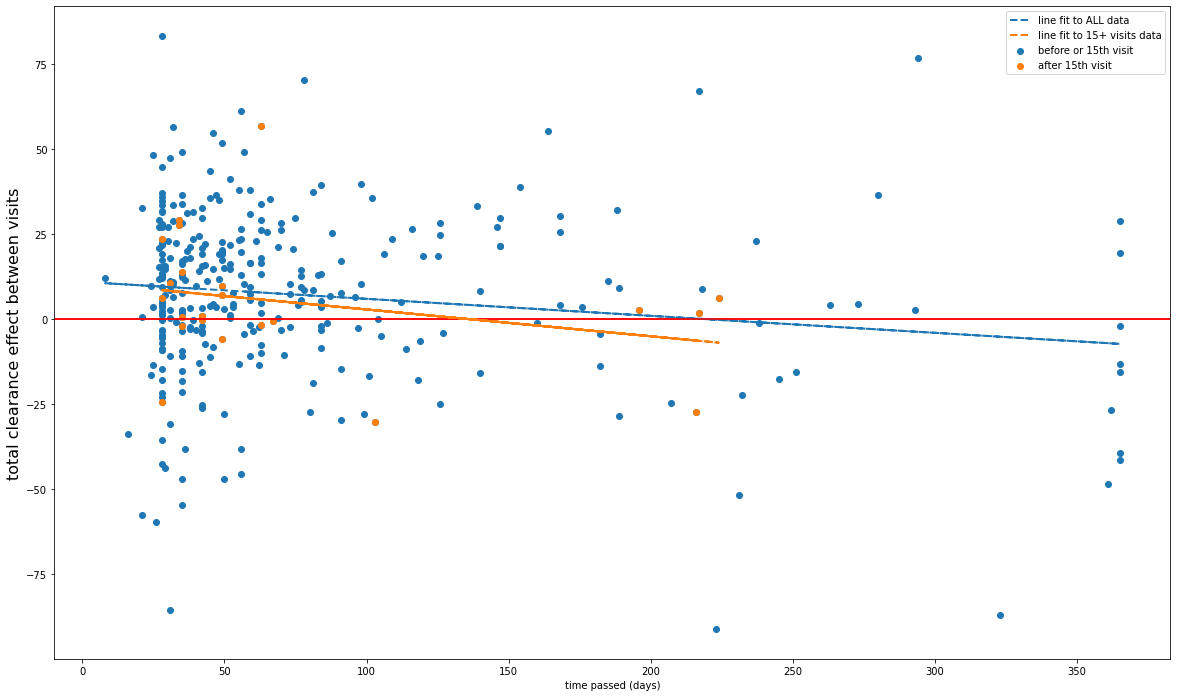

In [33]:
plt.figure(figsize=(20,12))
scatter_plot_against_time(non_moved_df, label = 'before or 15th visit', label2 ='line fit to ALL data')
scatter_plot_against_time(non_moved_df.loc[non_moved_df['visit_number'] > 15], label = 'after 15th visit', label2= 'line fit to 15+ visits data')
plt.legend()

### Scatted plots - divided into time groups:

0.007026365387323334
-0.14530548142261068
1.5945689831327972
0.1065448758072331
-0.1865918462119318
5.17493193064941
0.642075806843402
-0.0813905935269436
10.784199035935515
0.6960176555118331
-0.11477404107897553
24.45077511180623
0.6702788378686977
0.16558860675225623
24.57103051713275


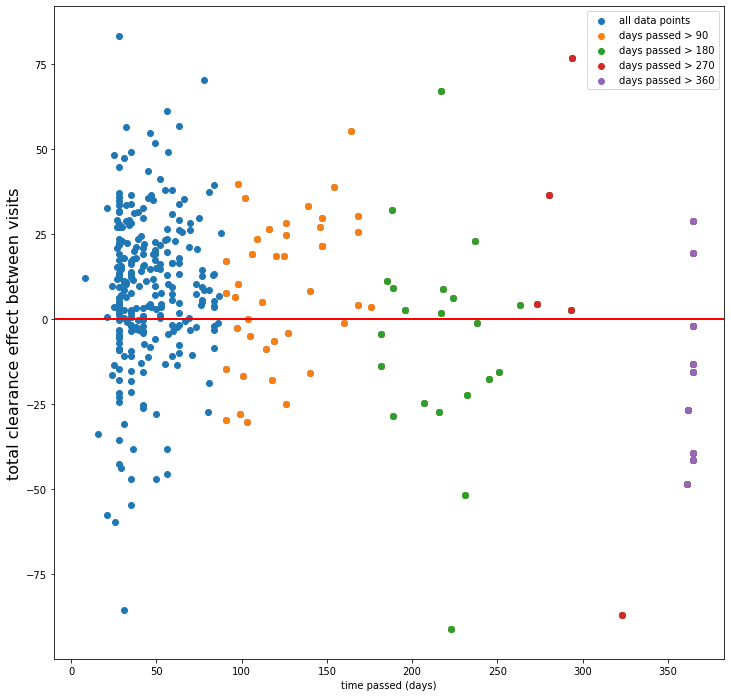

In [34]:
plt.figure(figsize=(12,12))
df0 = non_moved_df
df1 = non_moved_df.loc[non_moved_df['time'] > 90]
df2 = non_moved_df.loc[non_moved_df['time'] > 180]
df3 = non_moved_df.loc[non_moved_df['time'] > 270]
df4 = non_moved_df.loc[non_moved_df['time'] > 360]


scatter_plot_against_time(df0, label = 'all data points', label2 ='line fit to ALL data',plot_linear_fit = False)
scatter_plot_against_time(df1, label = 'days passed > 90', label2 ='',plot_linear_fit = False)
scatter_plot_against_time(df2, label = 'days passed > 180', label2 ='',plot_linear_fit = False)
scatter_plot_against_time(df3, label = 'days passed > 270', label2 ='',plot_linear_fit = False)
scatter_plot_against_time(df4, label = 'days passed > 360', label2 ='',plot_linear_fit = False)
plt.legend()

0.007026365387323334
-0.14530548142261068
1.5945689831327972
Pearsons correlation: -0.153
0.1065448758072331
-0.1865918462119318
5.17493193064941
Pearsons correlation: -0.237
0.642075806843402
-0.0813905935269436
10.784199035935515
Pearsons correlation: -0.139
0.6960176555118331
-0.11477404107897553
24.45077511180623
Pearsons correlation: -0.401


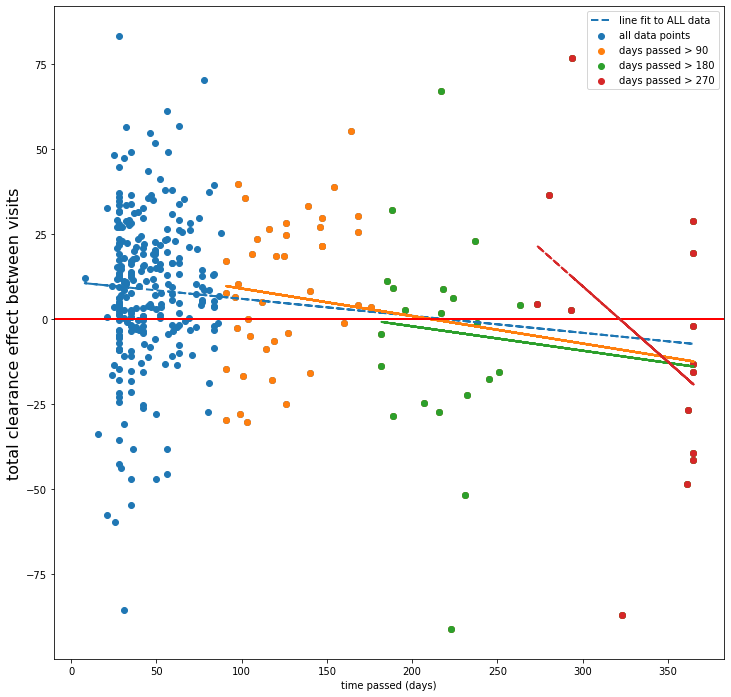

In [35]:
plt.figure(figsize=(12,12))
df0 = non_moved_df
df1 = non_moved_df.loc[non_moved_df['time'] > 90]
df2 = non_moved_df.loc[non_moved_df['time'] > 180]
df3 = non_moved_df.loc[non_moved_df['time'] > 270]


scatter_plot_against_time(df0, label = 'all data points', label2 ='line fit to ALL data')
scatter_plot_against_time(df1, label = 'days passed > 90', label2 ='')
scatter_plot_against_time(df2, label = 'days passed > 180', label2 ='')
scatter_plot_against_time(df3, label = 'days passed > 270', label2 ='')
plt.legend()

## Scatter plots - clearnce vs visit_nr

Pearsons correlation: -0.124


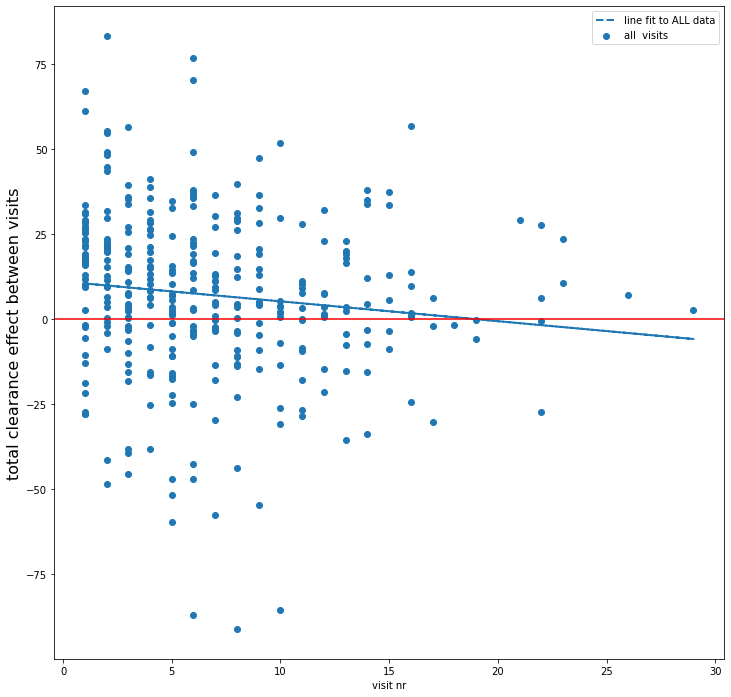

In [36]:
plt.figure(figsize=(12,12))
scatter_plot_against_visit_nr(non_moved_df, label = 'all  visits', label2 ='line fit to ALL data')
plt.legend()

##### Botplox explained:
<img src="boxplot_explained.png"
     alt="boxplot explained"/>

No handles with labels found to put in legend.


<Figure size 864x864 with 0 Axes>

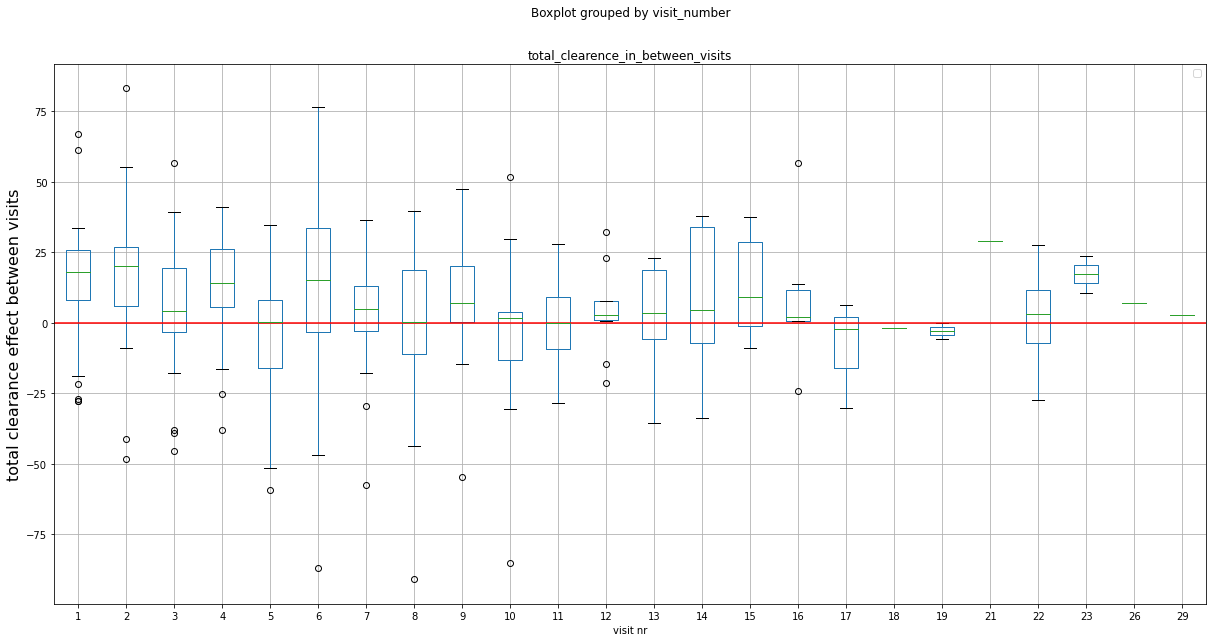

In [37]:
plt.figure(figsize=(12,12))
scatter_plot_against_visit_nr(non_moved_df, label = 'all  visits', label2 ='line fit to ALL data', plot_type='box', plot_linear_fit = False)
plt.legend()

Pearsons correlation: -0.040


<Figure size 864x864 with 0 Axes>

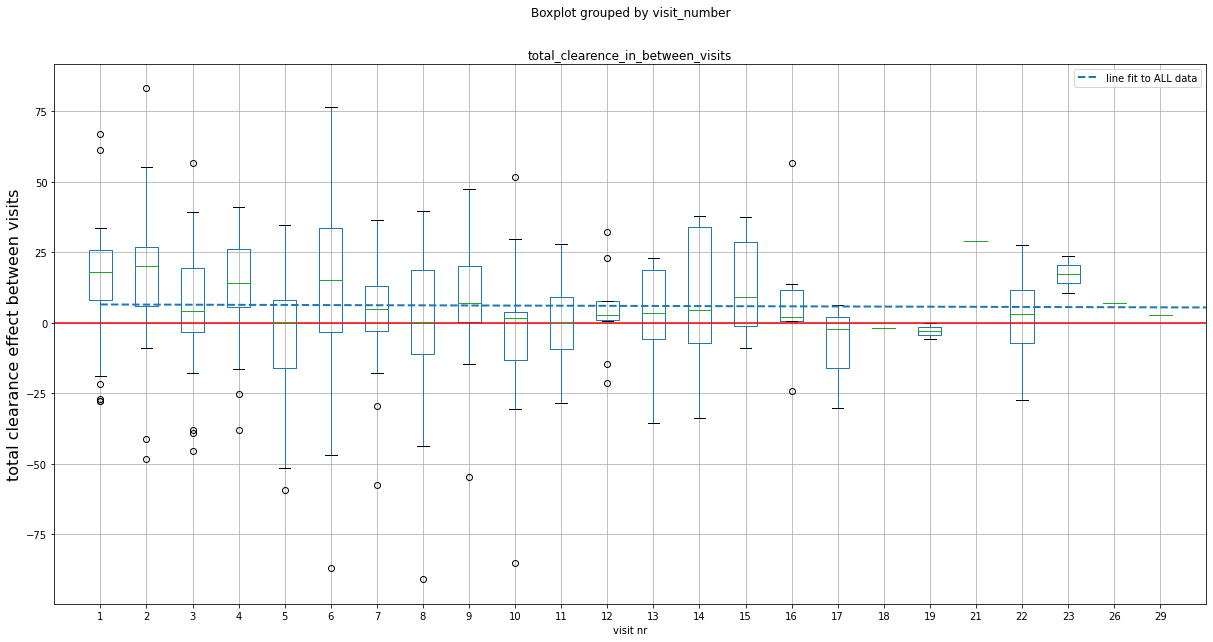

In [38]:
plt.figure(figsize=(12,12))
scatter_plot_against_visit_nr(non_moved_df, label = 'all  visits', label2 ='line fit to ALL data', plot_type='box', plot_linear_fit = True)
plt.legend()

### Statistical comparison of the means between 2 samples (data divided based on time)

In [39]:
non_moved_df

,surname,time,summed_time,time_group,visit_number,total_clearence_in_between_visits,total_clearence_in_respect_to_beginning,------------,nr_visit_group,below 0
0,1.Gasek,57,57,4,1,10.435940,10.435942,,0,False
1,1.Gasek,958,1015,4,2,-1.909880,8.725376,,0,True
2,1.Gasek,70,1085,4,3,-3.152340,5.848092,,1,True
3,1.Gasek,63,1148,4,4,26.204230,30.519873,,1,False
4,1.Gasek,238,1386,4,5,-0.996100,29.827784,,1,True
...,...,...,...,...,...,...,...,...,...,...
338,70. Wójcicki,84,255,4,6,-1.909880,75.286637,,1,True
339,70. Wójcicki,84,339,4,7,-3.152340,69.913296,,1,True
340,70. Wójcicki,70,409,4,8,26.204230,83.173308,,2,False
341,70. Wójcicki,160,569,4,9,-0.996100,74.593279,,2,True


In [40]:

for days_passed_threshold in [60,120,180,240,300,360]:
    print()
    ttest_against_time_threshold(non_moved_df, 
                                 time_threshold = days_passed_threshold, 
                                 related_ttest = False)




test for days passsed: 60
left mean: 7.989
right mean: 5.775
p_value: 0.2051


test for days passsed: 120
left mean: 8.182
right mean: 1.665
p_value: 0.0339


test for days passsed: 180
left mean: 8.734
right mean: -6.728
p_value: 0.0001


test for days passsed: 240
left mean: 7.938
right mean: -7.831
p_value: 0.0041


test for days passsed: 300
left mean: 8.046
right mean: -22.468
p_value: 0.0


test for days passsed: 360
left mean: 7.761
right mean: -15.302
p_value: 0.0022


### Statistical comparison of the means between 2 samples (data divided based on nr of visits)

In [41]:
1-3 -> srednia
4-6 -> srednia
7-9 -> srednia
10-13 -> srednia

wzgledne i bezwgledne statystyki (ttest independent and dependent)

SyntaxError: invalid syntax (<ipython-input-41-85ee5572df1d>, line 1)

In [ ]:
for visit_nr_threshold in [2,5,6,7,8,9,10,15,20,25]:
    print(f'TEST FOR FOR NR VISITORS: {visit_nr_threshold}')
    ttest_against_time_threshold(non_moved_df,
                                 visit_nr_threshold=visit_nr_threshold, 
                                 related_ttest = False)
                                 
    # ttest_against_time_threshold(non_moved_df,
    #                              visit_nr_threshold=visit_nr_threshold, 
    #                              related_ttest = True)
    print('\n\n\n')

TEST FOR FOR NR VISITORS: 2

test for nr visits: 2
left mean: 16.088
right mean: 4.483
p_value: 0.0001




TEST FOR FOR NR VISITORS: 5

test for nr visits: 5
left mean: 9.998
right mean: 4.428
p_value: 0.016




TEST FOR FOR NR VISITORS: 6

test for nr visits: 6
left mean: 10.19
right mean: 3.111
p_value: 0.0034




TEST FOR FOR NR VISITORS: 7

test for nr visits: 7
left mean: 9.398
right mean: 3.146
p_value: 0.0104




TEST FOR FOR NR VISITORS: 8

test for nr visits: 8
left mean: 8.527
right mean: 3.919
p_value: 0.0527




TEST FOR FOR NR VISITORS: 9

test for nr visits: 9
left mean: 8.538
right mean: 2.895
p_value: 0.0309




TEST FOR FOR NR VISITORS: 10

test for nr visits: 10
left mean: 7.896
right mean: 4.322
p_value: 0.133




TEST FOR FOR NR VISITORS: 15

test for nr visits: 15
left mean: 7.32
right mean: 4.768
p_value: 0.3157




TEST FOR FOR NR VISITORS: 20

test for nr visits: 20
left mean: 7.111
right mean: 8.824
p_value: 0.5832




TEST FOR FOR NR VISITORS: 25

test for nr 

# Exploratory area:

### New task by professor:
`Sprawdzic czy pierwsze dwie wizyty po x dlugosci czasu (90, 180, 270, 360 dni) maja dobre wymiary - tak jak pierwsze dwie wizyty → range for the beginning and the end`

In [ ]:
non_moved_df = get_data(format_type='all')
after_function = get_visits_after_wait_time_x(non_moved_df, 120)

default time group has GROUPS defined as: [0, 90, 180, 270, 360]


default time group has GROUPS defined as: [0, 90, 180, 270, 360]


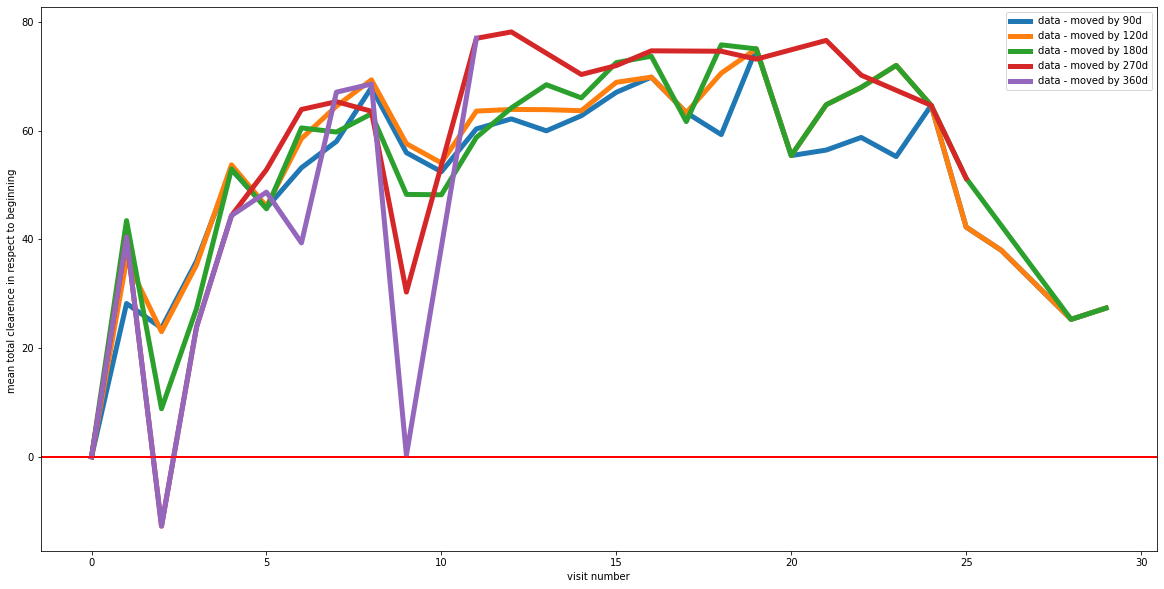

In [ ]:
plt.figure(figsize=(20,10))
data = get_data(format_type='all',remove_minus_ones = False)

data = get_visits_after_wait_time_x(data, 90)
data2 = get_visits_after_wait_time_x(data, 120)
data3 = get_visits_after_wait_time_x(data, 180)
data4 = get_visits_after_wait_time_x(data, 270)
data5 = get_visits_after_wait_time_x(data, 360)


agg_column_graph(data, label = 'data - moved by 90d', column = 'total_clearence_in_respect_to_beginning')
agg_column_graph(data2, label = 'data - moved by 120d', column = 'total_clearence_in_respect_to_beginning')
agg_column_graph(data3, label = 'data - moved by 180d', column = 'total_clearence_in_respect_to_beginning')
agg_column_graph(data4, label = 'data - moved by 270d', column = 'total_clearence_in_respect_to_beginning')
agg_column_graph(data5, label = 'data - moved by 360d', column = 'total_clearence_in_respect_to_beginning')

## Next steps (to be done by the end of the week)
1. Double check the data (try to automate it and then compare, or just look by the eye)
2. Add 4 new columns (changes in colours/area compared to beginning/previous visit)
3. Double check all calculations
4. Look into further statistics
